In [136]:
import logging
from pprint import pprint
import pandas as pd
import numpy as np
import statsmodels as sm
from statsmodels.tsa.stattools import kpss, adfuller
from matplotlib import pyplot as plt
from sklearn import tree
from inspect import getmembers
import seaborn as sns

In [3]:
def kpss_test(series, rejection_criteria=None):
    """
    null hypothesis: stationary with no unit root
    """
    if rejection_criteria is None:
        rejection_criteria=0.05
    statistic, p_value, n_lags, critical_values = kpss(series, nlags='auto')
    result = "not stationary" if p_value < rejection_criteria else "stationary"
    logging.warning("%r", f"statistic = {statistic}")
    logging.warning("%r", f"p_value = {p_value}")
    logging.warning("%r", f"n_lags = {n_lags}")
    logging.warning("%r", f"critical_values = {critical_values}")
    return p_value,result

def adf_test(series,rejection_criteria=None):
    """
    null hypothesis: random walk (not stationary)
    """
    if rejection_criteria is None:
        rejection_criteria=0.05
    (adf,p_value,usedlag,nobs,critical_values,icbest) = adfuller(series, autolag='AIC')
    result = "stationary" if p_value < rejection_criteria else "not stationary"
    logging.warning("%r", f"adf = {adf}")
    logging.warning("%r", f"p_value = {p_value}")
    logging.warning("%r", f"usedlag = {usedlag}")
    logging.warning("%r", f"nobs = {nobs}")
    logging.warning("%r", f"critical_values = {critical_values}")
    logging.warning("%r", f"icbest = {icbest}")    
    return p_value, result

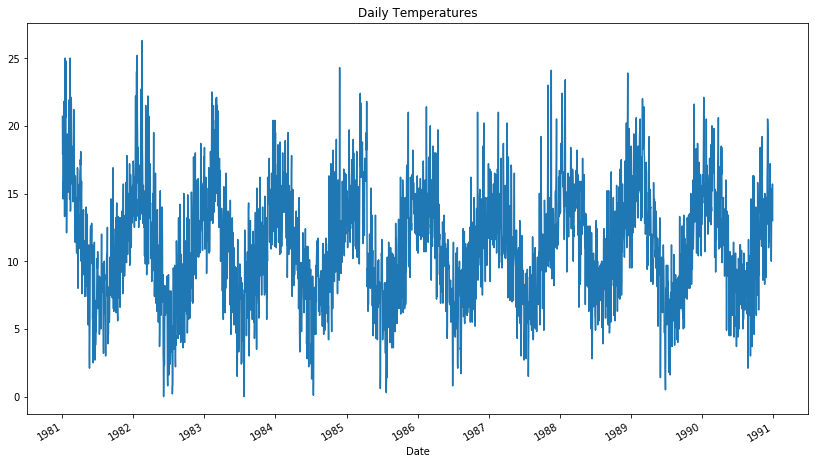

In [137]:
path = 'https://raw.githubusercontent.com/selva86/datasets/master/daily-min-temperatures.csv'
temp_df = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
temp_df.plot(title='Daily Temperatures', figsize=(14,8), legend=None);

In [138]:
kpss_test(temp_df['Temp'])

/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.1, 'stationary')

In [139]:
adf_test(temp_df['Temp'])

(0.0002470826300360895, 'stationary')

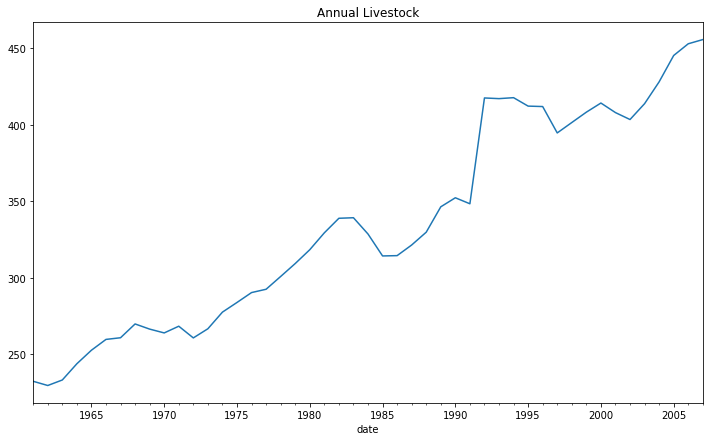

In [141]:
path = 'https://raw.githubusercontent.com/selva86/datasets/master/livestock.csv'
livestock_df = pd.read_csv(path, parse_dates=['date'], index_col='date')
livestock_df.plot.line(title='Annual Livestock', figsize=(12,7), legend=None)

In [142]:
kpss_test(livestock_df['value'])

/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(0.01, 'not stationary')

In [143]:
adf_test(livestock_df['value'])

(0.9337890318823667, 'not stationary')

In [144]:
livestock_df = livestock_df.reset_index()

In [145]:
X = livestock_df[['date']]
y = livestock_df[['value']]
clf = tree.DecisionTreeRegressor( max_depth=1)
clf = clf.fit(X, y)

In [146]:
clf.tree_.threshold[0]

6.784560207411282e+17

In [147]:
#pprint( getmembers( clf.tree_ ) )

[Text(167.4, 163.07999999999998, 'X[0] <= 6.784560207411282e+17\nmse = 4640.718\nsamples = 47\nvalue = 335.02'),
 Text(83.7, 54.360000000000014, 'mse = 1371.971\nsamples = 31\nvalue = 291.715'),
 Text(251.10000000000002, 54.360000000000014, 'mse = 300.538\nsamples = 16\nvalue = 418.924')]

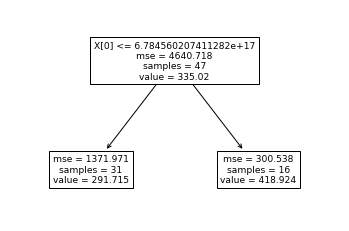

In [148]:
tree.plot_tree(clf)

In [149]:
predicted = pd.Series(clf.predict(X),name='predicted')

In [150]:
livestock_df = livestock_df.join(predicted,lsuffix='',rsuffix='_discard')

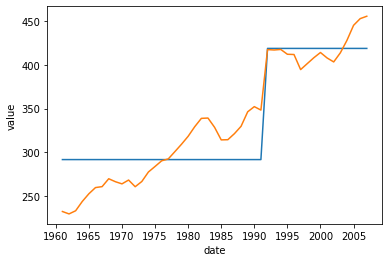

In [151]:
sns.lineplot(data=livestock_df,x='date',y='predicted')
sns.lineplot(data=livestock_df,x='date',y='value')

In [152]:
left_df = livestock_df[livestock_df['date'].astype(int)<=clf.tree_.threshold[0]]
right_df = livestock_df[livestock_df['date'].astype(int)>clf.tree_.threshold[0]]

In [153]:
kpss_test(left_df['value'])

/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(0.01, 'not stationary')

In [154]:
adf_test(left_df['value'])

(0.8365053861653565, 'not stationary')

In [155]:
kpss_test(right_df['value'])

(0.09664828973318108, 'stationary')

In [156]:
adf_test(right_df['value'])

(0.985199782946471, 'not stationary')

In [85]:
X = left_df[['date']]
y = left_df[['value']]
clf = tree.DecisionTreeRegressor( max_depth=1)
clf = clf.fit(X, y)

In [89]:
predicted_left = pd.Series(clf.predict(X),name='predicted_left')
livestock_df = livestock_df.join(predicted_left,lsuffix='',rsuffix='_discard')
livestock_df['predicted'] = livestock_df['predicted_left'].combine_first(livestock_df['predicted'])

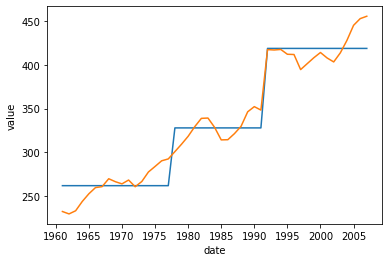

In [90]:
#sns.lineplot(data=livestock_df,x='date',y='predicted_left')
sns.lineplot(data=livestock_df,x='date',y='predicted')
sns.lineplot(data=livestock_df,x='date',y='value')

In [26]:
left_df = livestock_df[livestock_df['date'].astype(int)<=clf.tree_.threshold[0]]
right_df = livestock_df[livestock_df['date'].astype(int)>clf.tree_.threshold[0]]

In [27]:
kpss_test(left_df['value'])

(0.021395145687065797, 'not stationary')

In [28]:
kpss_test(right_df['value'])

/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(0.01, 'not stationary')

0     232.288994
1     229.536258
2     233.145936
3     243.763684
4     252.602916
5     259.677371
6     260.766892
7     269.784084
8     266.414974
9     263.917747
10    268.307222
11    260.662556
12    266.639419
13    277.515778
14    283.834045
15    290.309028
16    292.474198
17    300.830694
18    309.286657
19    318.331081
20    329.372390
21    338.883998
22    339.244126
23    328.600632
24    314.255385
25    314.459695
26    321.413779
27    329.789292
28    346.385165
29    352.297882
30    348.370515
31    417.562922
32    417.123570
33    417.749459
34    412.233904
35    411.946817
36    394.697075
37    401.499270
38    408.270468
39    414.242800
40    407.997978
41    403.460832
42    413.824928
43    428.104959
44    445.338742
45    452.994173
46    455.740170
Name: value, dtype: float64

In [128]:
def find_stationary(df,xcol='date',ycol='value'):
    if df.shape[0]<3:
        df['predicted'] = df[ycol].mean()
        return df
    X = df[[xcol]]
    y = df[[ycol]]
    (p_value, result) = kpss_test(df[ycol])
    if result=='stationary':
        df['predicted'] = df[ycol].mean()
        return df
    clf = tree.DecisionTreeRegressor(max_depth=1)
    clf = clf.fit(X, y)
    split=clf.tree_.threshold[0]
    
    left_df = df.loc[df[xcol]<=split,[xcol,ycol]]
    right_df = df.loc[df[xcol]>split,[xcol,ycol]]
    
    left_df = find_stationary(left_df[[xcol,ycol]])
    right_df = find_stationary(right_df[[xcol,ycol]])
    df['predicted'] = left_df['predicted'].combine_first(right_df['predicted'])
    return df

In [129]:
livestock_df = pd.read_csv(path, parse_dates=['date'], index_col='date')
livestock_df = livestock_df.reset_index()
livestock_df['date'] = livestock_df['date'].astype(int)
result = find_stationary(livestock_df)

/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


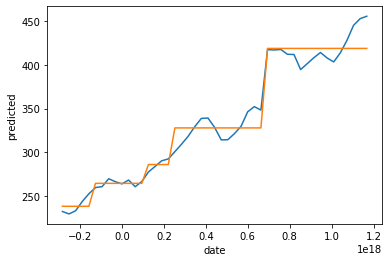

In [130]:
sns.lineplot(data=result,x='date',y='value')
sns.lineplot(data=result,x='date',y='predicted')

In [133]:
temp_df = temp_df.reset_index()
temp_df['Date'] = temp_df['Date'].astype(int)
temp_result = find_stationary(temp_df,xcol='Date',ycol='Temp')

/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


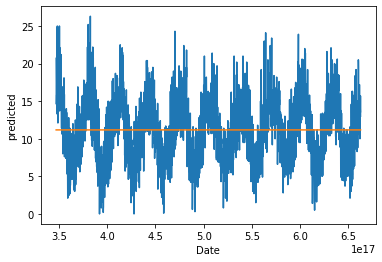

In [135]:
sns.lineplot(data=temp_result,x='Date',y='Temp')
sns.lineplot(data=temp_result,x='Date',y='predicted')